In [37]:
from typing import Optional, Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import evaluate
import os
from scipy.special import softmax

from pathlib import Path
import wandb
from datasets import Dataset # HuggingFace
from dataclasses import dataclass
from transformers import AutoTokenizer
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer, AutoModel, IntervalStrategy

In [6]:
import logging
#logging.basicConfig(level=logging.DEBUG, format='%(asctime)s %(message)s')

In [7]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'DeBERTa V3 Osmulski.ipynb'

In [8]:
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [9]:
# !conda install wandb -y

In [10]:
# !pip install seaborn

In [11]:
deberta_v3_large = 'microsoft/deberta-v3-large'

In [12]:
df_test = pd.read_csv('data/train.csv')
df_test = df_test.drop(columns="id")
df_test.columns

Index(['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'], dtype='object')

In [13]:
df_6000 = pd.read_csv('data/osmulski_6000.csv')
df_train = df_6000[:5800]
df_test_1 = df_6000[5800:]
df_test_2 = pd.read_csv('data/osmulski_extra_train.csv')
print(df_train.shape, df_test_1.shape, df_test_2.shape)

(5800, 7) (200, 7) (500, 7)


In [14]:
option_to_index = {option: idx for idx, option in enumerate('ABCDE')}
index_to_option = {v: k for k,v in option_to_index.items()}

def preprocess(example):
    first_sentence = [example['prompt']] * 5
    second_sentences = [example[option] for option in 'ABCDE']
    tokenized_example = tokenizer(first_sentence, second_sentences, truncation=True)
    tokenized_example['label'] = option_to_index[example['answer']]
    
    return tokenized_example

@dataclass
class DataCollatorForMultipleChoice:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    
    def __call__(self, features):
        label_name = 'label' if 'label' in features[0].keys() else 'labels'
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]['input_ids'])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])
        
        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors='pt',
        )
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        batch['labels'] = torch.tensor(labels, dtype=torch.int64)
        return batch

In [15]:
deberta_v3_large = 'microsoft/deberta-v3-large'
tokenizer = AutoTokenizer.from_pretrained(deberta_v3_large)

train_dataset = Dataset.from_pandas(df_train, preserve_index=False)
tokenized_train = train_dataset.map(preprocess, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'])
tokenized_train

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/daniel/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/5800 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 5800
})

In [16]:
test_dataset = Dataset.from_pandas(df_test)
tokenized_test = test_dataset.map(preprocess, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'])
tokenized_test

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 200
})

## Training

In [17]:
def precision_at_k(predictions, actuals, k=3):        
    if isinstance(actuals, list):
        actuals = np.array(actuals)
        
    found_at = np.where(predictions == actuals.reshape(-1, 1))
    # found_at is a tuple with the array of found indices in the second position
    score = 1 / (1 + found_at[1])
    score[score < 1/k] = 0
    return score

def mean_avg_precision_at_k(predictions, actual, k=3):
    n = predictions.shape[0]
    row_precision = precision_at_k(predictions, actual)
    return row_precision.sum()/n

In [18]:
def score_random():
    n_permutations = 200
    n_numbers = 5 
    # In this code, np.random.rand(n_permutations, n_numbers) generates a 2D array of random numbers.
    # argsort(axis=1) then sorts along the second dimension (i.e., sorts each row) but instead of 
    # sorting the actual numbers, it sorts their indices, effectively creating a permutation.
    random_predictions = np.random.rand(n_permutations, n_numbers).argsort(axis=1)
    random_actuals = np.random.randint(0, n_numbers-1, n_permutations)
    return mean_avg_precision_at_k(random_predictions, random_actuals)
    
scores = []
for i in range(100000):
    scores.append(score_random())

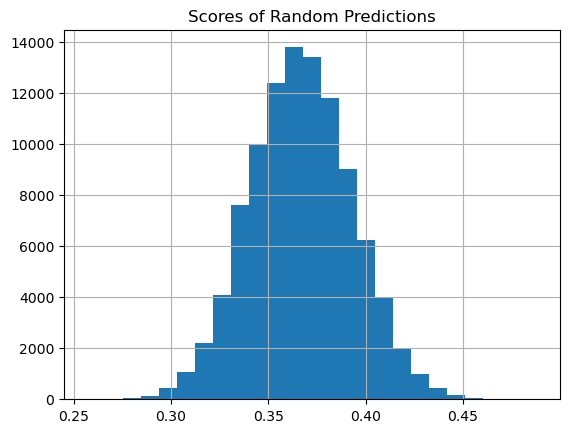

In [19]:
pd.Series(scores).hist(bins=25)
plt.title('Scores of Random Predictions');

In [20]:
acc_metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.flip(predictions.argsort(axis=1), axis=1)
    accuracy = acc_metric.compute(predictions=predictions[:,0], references=labels)['accuracy']
    map_at_3 = mean_avg_precision_at_k(predictions, labels)
    return {
        'accuracy': accuracy,
        'map_at_3': round(map_at_3, 3)
    }

In [22]:
retrain = False

output_path = Path('./checkpoints')
training_args = TrainingArguments(
    warmup_ratio=0.8,
    learning_rate=5e-6,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=10,
    evaluation_strategy = IntervalStrategy.STEPS,
    logging_steps=10,
    eval_steps=250,
    num_train_epochs=3,
    save_steps=5000,
    report_to='wandb',
    output_dir=str(output_path),
    run_name='Train on reduced Osmulski'
)

if not output_path.exists() or retrain:
    model = AutoModelForMultipleChoice.from_pretrained(deberta_v3_large)
    trainer = Trainer(
        model=model,
        args=training_args,
        tokenizer=tokenizer,
        data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer),
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics,
    )
    
    trainer.train()
    wandb.finish()
else:
    model = AutoModelForMultipleChoice.from_pretrained(output_path/'checkpoint-19500')

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2ForMultipleChoice: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2ForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassif

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy,Map At 3
250,1.612600,1.609225,0.270000,0.430000
500,1.616300,1.608112,0.345000,0.514000
750,1.633900,1.605333,0.435000,0.613000
1000,1.586800,1.602573,0.565000,0.704000
1250,1.535900,1.529727,0.570000,0.718000
1500,1.243800,1.175112,0.650000,0.776000
1750,1.245200,1.041963,0.660000,0.788000
2000,1.110300,0.987762,0.675000,0.792000
2250,1.207200,0.973011,0.670000,0.785000
2500,1.037800,0.956732,0.665000,0.786000


eval/accuracy,▁▂▄▆▆▇████████▇█▇
eval/loss,████▇▄▃▂▂▂▂▁▁▁▂▁▁
eval/map_at_3,▁▃▄▆▆█████████▇██
eval/runtime,▁▃▄▅▄▆▆▆▇▇▆▆▆▆█▇█
eval/samples_per_second,█▆▅▄▅▃▃▃▂▂▃▃▃▃▁▂▁
eval/steps_per_second,█▆▅▄▅▃▃▃▂▂▃▃▃▃▁▂▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇████▇▆▅▄▃▂▁
train/loss,███████████▇▆▆▅▅▇▄▅▅▅▇▅▃▄▄▅▃▃▁▃▄▂▃▂▃▃▄▂▃
train/total_flos,▁


## Predicting on the Testset

In [23]:
def evaluate_model(test_set):
    tokenized_test_dataset = Dataset.from_pandas(test_set).map(preprocess, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E'])
    test_predictions = trainer.predict(tokenized_test_dataset).predictions
    print(compute_metrics([test_predictions, tokenized_test_dataset['label']]))
    
evaluate_model(df_test)
evaluate_model(df_test_1)
evaluate_model(df_test_2)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

{'accuracy': 0.645, 'map_at_3': 0.771}


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

{'accuracy': 0.55, 'map_at_3': 0.702}


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

{'accuracy': 0.554, 'map_at_3': 0.701}


In [31]:
trainer_predict = trainer.predict(tokenized_test_dataset)

In [36]:
trainer_predict.predictions?

Type:        ndarray
String form:
[[-9.81499255e-01  1.33976841e+00  1.60739362e+00  4.27693319e+00
           6.14280045e-01]
           [ 1.4250420 <...> 324652e+00]
           [-1.70279473e-01 -3.30993199e+00 -1.98556447e+00 -9.87624466e-01
           -2.38353133e+00]]
Length:      200
File:        ~/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/__init__.py
Docstring:  
ndarray(shape, dtype=float, buffer=None, offset=0,
        strides=None, order=None)

An array object represents a multidimensional, homogeneous array
of fixed-size items.  An associated data-type object describes the
format of each element in the array (its byte-order, how many bytes it
occupies in memory, whether it is an integer, a floating point number,
or something else, etc.)

Arrays should be constructed using `array`, `zeros` or `empty` (refer
to the See Also section below).  The parameters given here refer to
a low-level method (`ndarray(...)`) for instantiating an array.

For more information, re

In [44]:
tokenized_test_dataset = Dataset.from_pandas(df_test).map(preprocess, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E'])
test_logits = trainer.predict(tokenized_test_dataset).predictions
test_probs = softmax(test_logits, axis=1)
predictions = np.flip(test_logits.argsort(axis=1), axis=1)
pred_1 = predictions[:, 0]
pred_2 = predictions[:, 1]
pred_3 = predictions[:, 2]

row_indcs = np.arange(pred_1.shape[0])
res = pd.DataFrame({
    'pred_1': pred_1, 
    'prob_1': test_probs[row_indcs, pred_1],
    'pred_2': pred_2, 
    'prob_2': test_probs[row_indcs, pred_2],
    'pred_3': pred_3, 
    'prob_3': test_probs[row_indcs, pred_3],
    'logit_sum': test_probs.sum(axis=1),
    'prob_3_sum': test_probs[row_indcs, pred_1] + test_probs[row_indcs, pred_2] + test_probs[row_indcs, pred_3],
    'actual': tokenized_test_dataset['label'],
    'accurate': pred_1 == tokenized_test_dataset['label'],
    'precision_at_3': precision_at_k(predictions, tokenized_test_dataset['label']).round(2)
})

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [45]:
res[:40]

,pred_1,prob_1,pred_2,prob_2,pred_3,prob_3,logit_sum,prob_3_sum,actual,accurate,precision_at_3
0,3,0.867177,2,0.060082,1,0.045974,1.0,0.973232,3,True,1.00
1,2,0.384794,3,0.229879,0,0.216674,1.0,0.831346,0,False,0.33
2,0,0.692946,2,0.154489,4,0.092092,1.0,0.939527,0,True,1.00
3,2,0.350951,1,0.244707,0,0.237140,1.0,0.832798,2,True,1.00
4,0,0.345061,3,0.286901,1,0.263349,1.0,0.895311,3,False,0.50
5,1,0.674848,2,0.183446,3,0.059358,1.0,0.917651,1,True,1.00
6,0,0.599422,2,0.315494,1,0.076119,1.0,0.991035,0,True,1.00
7,3,0.540555,1,0.352013,4,0.096040,1.0,0.988608,3,True,1.00
8,0,0.509058,1,0.390489,2,0.080096,1.0,0.979643,2,False,0.33
9,0,0.997954,1,0.001455,4,0.000338,1.0,0.999747,0,True,1.00


In [46]:
res['precision_at_3'].value_counts()

1.00    129
0.50     39
0.33     17
0.00     15
Name: precision_at_3, dtype: int64

<Axes: >

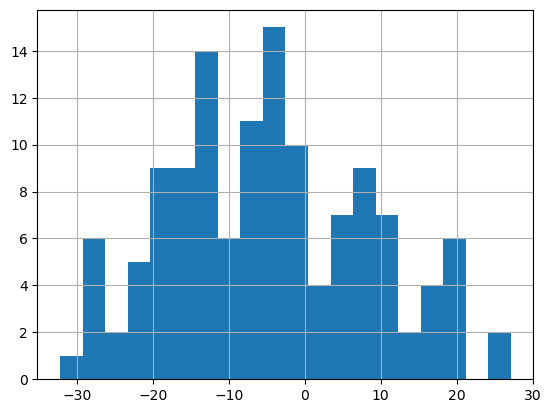

In [30]:
res[res['accurate']]['prob_sum'].hist(bins=20)

In [50]:
type()

list

In [ ]:
predictions_as_ids = np.argsort(-test_predictions, 1)
predictions_as_ids[:3]

In [28]:
predictions_as_answer_letters = np.array(list('ABCDE'))[predictions_as_ids]
predictions_as_answer_letters[:3]

NameError: name 'predictions_as_ids' is not defined

In [19]:
predictions_as_string = df_test['prediction'] = [
    ' '.join(row) for row in predictions_as_answer_letters[:, :3]
]
predictions_as_string[:3]

['D B C', 'A E B', 'A C E']